Start of epoch 0
Training loss (batch) at step 0: mse: 2.358168601989746, topo: 28310.328514063815, total:5.189201354980469
Start of epoch 1
Training loss (batch) at step 0: mse: 0.9391231536865234, topo: 3394.875056801343, total:1.2786107063293457
Start of epoch 2
Training loss (batch) at step 0: mse: 0.8234698176383972, topo: 5610.616128466247, total:1.3845314979553223
Start of epoch 3
Training loss (batch) at step 0: mse: 0.6894087791442871, topo: 9323.571691958165, total:1.6217659711837769
Start of epoch 4
Training loss (batch) at step 0: mse: 0.7027209401130676, topo: 9577.136605014775, total:1.660434603691101
Start of epoch 5
Training loss (batch) at step 0: mse: 0.672515332698822, topo: 10784.006443750513, total:1.7509160041809082
Start of epoch 6
Training loss (batch) at step 0: mse: 0.8006253242492676, topo: 14237.948380667665, total:2.2244200706481934
Start of epoch 7
Training loss (batch) at step 0: mse: 0.7050362229347229, topo: 15370.782914248257, total:2.242114543914795
S

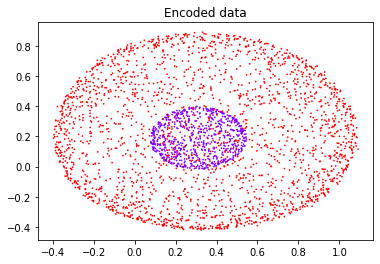

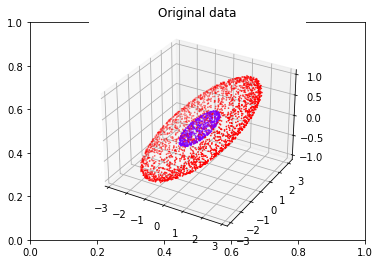

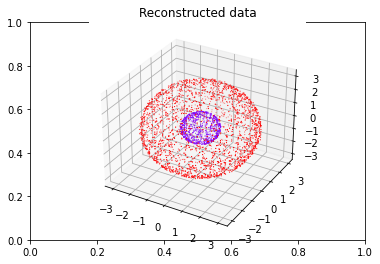

In [7]:
#%%

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Layer, Input
from tensorflow.keras import losses, Input
from tensorflow.keras import backend as K


from topolearn.util import make_shells
from topolearn import simpcomplex
from topolearn import autoencoder as topoauto

# Dimension of the original space
input_dim = 3
# Dimension of the latent space (encoding space)
latent_dim = 2
y, X = make_shells(3000, input_dim, noise=0.01)

# Autoencoder  model
encoder = Sequential(
    [
        Input(shape=(input_dim,)),
        Dense(256, activation="elu"),
        Dense(128, activation="elu"),
        Dense(64, activation="elu"),
        Dense(32, activation="elu"),
        Dense(latent_dim, activation="elu"),
    ]
)
decoder = Sequential(
    [
        Dense(64, activation="elu", input_shape=(latent_dim,)),
        Dense(128, activation="elu"),
        Dense(256, activation="elu"),
        Dense(input_dim, activation=None),
    ]
)
input_seq = encoder.input
output_seq = decoder(encoder.output)
model = Model(inputs=input_seq, outputs=output_seq)


# Training config
epochs = 20
batch_size = 130
lambda_topo = 0.0001
learning_rate = 1e-3
#
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_mse = keras.losses.MeanSquaredError()
topoloss = topoauto.TopologicalLoss(
    filtration=simpcomplex.RipsComplex(max_dim=1, max_radius=0.8, verbose=0),
)

losses_mse = []
losses_topo = []

train_dataset = X
train_dataset = tf.data.Dataset.from_tensor_slices((X, X))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

for epoch in range(epochs):
    print(f"Start of epoch {epoch}")
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            middle = encoder(x_batch_train, training=True)
            preds = decoder(middle, training=True)

            loss_accuracy = loss_mse(y_batch_train, preds)
            loss_topo = topoloss(x_batch_train, middle)
            loss_value = loss_accuracy + lambda_topo * loss_topo

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        losses_mse.append(loss_accuracy)
        losses_topo.append(loss_topo)

        if step % 200 == 0:
            print(
                f"Training loss (batch) at step {step}: mse: {loss_accuracy}, topo: {loss_topo}, total:{loss_value}"
            )


encoded = encoder(X)

Xaut = model.predict(X)

# Plot, plot, plot
plt.figure()
plt.title("Encoded data")
plt.scatter(encoded[:, 0], encoded[:, 1], c=y, cmap="rainbow", s=0.5)
plt.figure()
plt.title("Original data")
ax = plt.axes(projection="3d")
ax.scatter(Xaut[:, 0], Xaut[:, 1], Xaut[:, 2], c=y, cmap="rainbow", s=0.5)
plt.figure()
plt.title("Reconstructed data")
ax = plt.axes(projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap="rainbow", linewidth=0.5, s=0.5)

plt.figure()
plt.title("Topological loss")
plt.plot(losses_topo)

plt.figure()
plt.title("Reconstruction loss")
plt.plot(losses_mse)






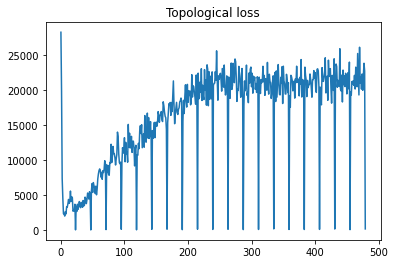

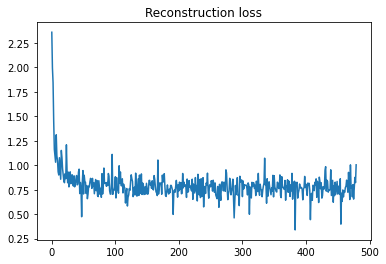

In [9]:
epochs = 500
batch_size = 100
lambda_topo = 0.0001
learning_rate = 1e-3


